<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/nlp/Langchain_Mistral_T5_Document_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.0 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off

In [2]:
!pip install sentence-transformers spacy langchain trl datasets pypdf -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.7/806.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.0/237.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#token limits
Mistral 7B
https://huggingface.co/mistralai/Mistral-7B-v0.1/discussions/104

# GPT-4
What is the maximum input length for GPT-4?
The input character limit for this version of GPT (GPT-4) is 8,192 tokens. Keep in mind that tokens can be parts of words, whole words, or several words, depending on the language and context. The input size for GPT (including this version, GPT-4) is 4096 tokens. This includes both the prompt and the system's response.


https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken


Sentence Transformer
https://huggingface.co/sentence-transformers/all-mpnet-base-v2


In [3]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file = "/content/drive/MyDrive/data/text.txt"
with open(file) as f:
    text = f.read()

In [6]:
text

'Madam Speaker, Madam Vice President, our First Lady and Second Gentleman.\n\nMembers of Congress and the Cabinet.\n\nJustices of the Supreme Court.\n\nMy fellow Americans.  \n\n\n\nLast year COVID-19 kept us apart.\n\nThis year we are finally together again. \n\n\n\nTonight, we meet as Democrats Republicans and Independents.\n\nBut most importantly as Americans. \n\n\n\nWith a duty to one another to the American people to the Constitution. \n\n\n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\n\n\nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways.\n\nBut he badly miscalculated. \n\n\n\nHe thought he could roll into Ukraine and the world would roll over.\n\nInstead he met a wall of strength he never imagined. \n\n\n\nHe met the Ukrainian people. \n\n\n\nFrom President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determination, inspires t

In [7]:
count_start_and_stop_tokens = 2
text_token_count = splitter.count_tokens(text=text) - count_start_and_stop_tokens

token_multiplier = splitter.maximum_tokens_per_chunk // text_token_count + 1
text_to_split = text * token_multiplier

text_chunks = splitter.split_text(text=text_to_split)
print(text_token_count)

189


In [8]:
# Import libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import transformers
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
device

'cuda'

In [10]:
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1", load_in_4bit=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [11]:
# Test prompt 1
vegeterian_recipe_prompt = """### Instruction: Act as a gourmet chef.
I have a friend coming over who is a vegetarian.
I want to impress my friend with a special vegetarian dish.
What do you recommend?

Give me two options, along with the whole recipe for each.

 ### Answer:
 """

encoded_instruction = tokenizer(vegeterian_recipe_prompt,  return_tensors="pt", add_special_tokens=True)

model_inputs = encoded_instruction.to(device)

generated_ids = model.generate(**model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:224: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(f'Input type into Linear4bit is torch.float16, but bnb_4bit_compute_type=torch.float32 (default). This will lead to slow inference or training speed.')


<s> ### Instruction: Act as a gourmet chef.
I have a friend coming over who is a vegetarian.
I want to impress my friend with a special vegetarian dish.
What do you recommend?

Give me two options, along with the whole recipe for each.

 ### Answer:
 
Option 1: Roasted Butternut Squash Risotto
Ingredients:
- 1 large butternut squash
- 1 onion, finely chopped
- 4 cloves of garlic, minced
- 1 cup of arborio rice
- 4 cups of vegetable broth
- 1/2 cup of grated parmesan cheese
- Salt and pepper to taste
- A handful of chopped parsley

Instructions:
1. Preheat the oven to 400°F and cut the butternut squash in half and remove the seeds.
2. Place the squash on a baking sheet and roast for about 40 minutes or until the skin is crispy and the flesh is tender.
3. In a large pot, melt some butter or olive oil and sauté the onion and garlic until they are translucent.
4. Add the arborio rice and stir until it is coated in oil and onions.
5. Gradually add the vegetable broth, stirring continuously 

In [12]:
PROMPT= """ ### Instruction: Act as a currency expert.

### Question:
Explain to me how Digital Currency works. Assume that I am a 5-year-old child.

 ### Answer:
 """



In [13]:
encoded_instruction = tokenizer(PROMPT,  return_tensors="pt", add_special_tokens=True)

model_inputs = encoded_instruction.to(device)

generated_ids = model.generate(**model_inputs, max_new_tokens=1000, do_sample=True, pad_token_id=tokenizer.eos_token_id)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])

<s>  ### Instruction: Act as a currency expert.

### Question:
Explain to me how Digital Currency works. Assume that I am a 5-year-old child.

 ### Answer:
  Okay! So, you know how we use money to buy things, like candy or toys? Well, digital currency is just like that, but it's all online. Instead of using paper and coins, we use computers and the internet to exchange and store these digital coins, or tokens. It's like having a special kind of money only for online shopping and games. And because it's all digital, it's much easier and more secure to use and keep track of. It's like having a super toy wallet on your computer that you can use to buy things and play games with your friends all over the world!</s>


In [14]:
text_generation_pipeline = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=1000,

)

In [15]:
mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)

In [16]:
prompt_template = """
### Instruction: Act as a LARGE Language Models Expert. I will ask you a QUESTION and give you an AUDIENCE PERSONA, and you will respond with an answer easily understandable by the AUDIENCE PERSONA.

### AUDIENCE PERSONA:
{audience_persona}

### QUESTION:
{question}

 ### Answer:
 """

In [18]:
# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["audience_persona", "question"],
    template=prompt_template,
)

# Create llm chain
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt, verbose=True)

In [19]:
# Input query to LLM
input_text = {
    "audience_persona": "A 5 year-old child",
    "question": "Explain how Large Language Models work."
}

# Generate and print LLM response
response = llm_chain(input_text)


#print(response_text['text'])

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new LLMChain chain...
Prompt after formatting:

### Instruction: Act as a LARGE Language Models Expert. I will ask you a QUESTION and give you an AUDIENCE PERSONA, and you will respond with an answer easily understandable by the AUDIENCE PERSONA.

### AUDIENCE PERSONA:
A 5 year-old child

### QUESTION:
Explain how Large Language Models work.

 ### Answer:
 

> Finished chain.


In [20]:
response['text']

"\nLarge language models are like super smart computers that can understand and talk about anything! They're made up of lots of tiny computers working together, and they learn from all the things people write online. Just like how you learn new things by asking questions and listening to others, these big computers learn by reading and understanding what people say on the internet. And because they're so smart, they can even make up their own words and stories sometimes! It's like having a magic friend who can talk and think for you."

In [21]:
response

{'audience_persona': 'A 5 year-old child',
 'question': 'Explain how Large Language Models work.',
 'text': "\nLarge language models are like super smart computers that can understand and talk about anything! They're made up of lots of tiny computers working together, and they learn from all the things people write online. Just like how you learn new things by asking questions and listening to others, these big computers learn by reading and understanding what people say on the internet. And because they're so smart, they can even make up their own words and stories sometimes! It's like having a magic friend who can talk and think for you."}

In [22]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-large")
model = T5ForConditionalGeneration.from_pretrained("t5-large")



spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use th

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [23]:
text_summarization_pipeline = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="summarization",
    temperature=0.2,
    repetition_penalty=1.1,
      max_new_tokens=1000,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,


)
llm = HuggingFacePipeline(pipeline=text_summarization_pipeline)

In [24]:
prompt = """
Please provide a summary of the following text

TEXT:
Philosophy (from Greek: φιλοσοφία, philosophia, 'love of wisdom') \
is the systematized study of general and fundamental questions, \
such as those about existence, reason, knowledge, values, mind, and language. \
Some sources claim the term was coined by Pythagoras (c. 570 – c. 495 BCE), \
although this theory is disputed by some. Philosophical methods include questioning, \
critical discussion, rational argument, and systematic presentation.
"""

In [25]:
num_tokens = llm.get_num_tokens(prompt)
print (f"Our prompt has {num_tokens} tokens")

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Our prompt has 121 tokens


In [26]:
output = llm(prompt)
print (output)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
Your max_length is set to 200, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


philosophy is the systematized study of general and fundamental questions . some sources claim term was coined by Pythagoras, although this theory is disputed . philosophical methods include questioning, critical discussion, rational argument .


In [28]:
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader

In [29]:
# Load the book
loader = PyPDFLoader("/content/drive/MyDrive/data/IntoThinAirBook.pdf")
pages = loader.load()

# Cut out the open and closing parts
pages = pages[26:277]

# Combine the pages, and replace the tabs with spaces
text = ""

for page in pages:
    text += page.page_content

text = text.replace('\t', ' ')

In [30]:
num_tokens = llm.get_num_tokens(text)

print (f"This book has {num_tokens} tokens in it")

Token indices sequence length is longer than the specified maximum sequence length for this model (139734 > 1024). Running this sequence through the model will result in indexing errors


This book has 139734 tokens in it


In [31]:
# Loaders
from langchain.schema import Document

# Splitters
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Model


# Embedding Support
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# Summarizer we'll use for Map Reduce
from langchain.chains.summarize import load_summarize_chain

# Data Science
import numpy as np
from sklearn.cluster import KMeans

In [32]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=10000, chunk_overlap=3000)

docs = text_splitter.create_documents([text])

In [33]:
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 78 documents


In [34]:
embeddings = HuggingFaceEmbeddings()

vectors = embeddings.embed_documents([x.page_content for x in docs])

In [36]:
len(vectors[0])

768

In [37]:
vectors[0]

[0.051463533192873,
 0.03770192340016365,
 0.007584839127957821,
 0.031861331313848495,
 0.006811570376157761,
 -0.06697043776512146,
 -0.03992162272334099,
 0.010773359797894955,
 0.09493384510278702,
 0.008275782689452171,
 0.027313023805618286,
 0.047203876078128815,
 -0.005260020028799772,
 0.010866869240999222,
 -0.0014968180330470204,
 -0.10422512143850327,
 -0.019341468811035156,
 -0.0003376283566467464,
 -0.03270051255822182,
 0.021068338304758072,
 -0.04441859945654869,
 -0.009201676584780216,
 0.0023672454990446568,
 -0.014716005884110928,
 0.07827586680650711,
 -0.02023036777973175,
 0.011472181417047977,
 0.02797878347337246,
 0.06382003426551819,
 -0.08740724623203278,
 -0.039127662777900696,
 -0.029170604422688484,
 -0.0009259111830033362,
 -0.009944901801645756,
 2.7350092750566546e-06,
 -0.004626710899174213,
 -0.0004938138299621642,
 0.0016884986544027925,
 -0.07844030857086182,
 -0.06294049322605133,
 -0.026051875203847885,
 -0.013497271575033665,
 0.01644408702850341

In [38]:
# Assuming 'embeddings' is a list or array of 768-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# I played around and found ~10 was the best.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 21

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [39]:
kmeans.labels_

array([15, 12, 15, 20, 12, 12, 12, 12, 12,  8,  1,  5, 15, 18, 14, 14,  3,
       16,  2, 15, 12, 12, 15,  4, 16,  1,  5,  5,  4, 13, 11, 16, 12, 12,
        3, 16,  6,  6,  6,  2,  6, 17,  6, 16, 15, 15,  6,  2,  6,  6, 17,
        0,  6,  9,  2,  7, 17,  6, 19, 17, 16,  2,  0, 15,  2,  1,  3,  3,
        6, 12, 11,  7,  7, 10,  7,  7, 10, 10], dtype=int32)

In [40]:
len(kmeans.labels_)

78

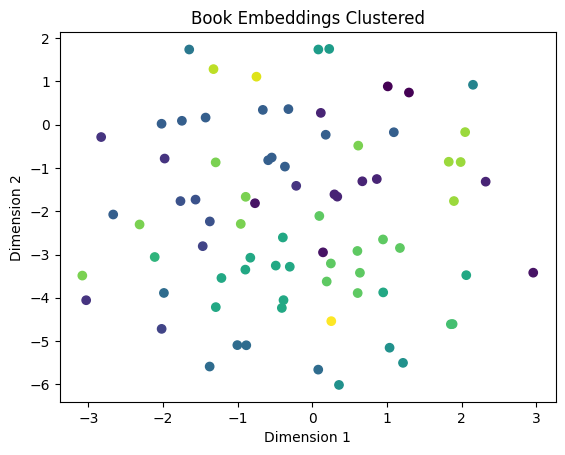

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
# Taking out the warnings
import warnings
from warnings import simplefilter

# Filter out FutureWarnings
simplefilter(action='ignore', category=FutureWarning)

# Perform t-SNE and reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Plot the reduced data
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered')
plt.show()

In [42]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

In [43]:
selected_indices = sorted(closest_indices)
selected_indices

[0,
 3,
 6,
 9,
 10,
 11,
 13,
 14,
 23,
 29,
 31,
 47,
 49,
 50,
 51,
 53,
 58,
 66,
 70,
 75,
 77]

In [44]:
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [45]:
map_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=map_prompt_template)

In [46]:
selected_docs = [docs[doc] for doc in selected_indices]

In [47]:
# Make an empty list to hold your summaries
summary_list = []

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):

    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])

    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
Token indices sequence length is longer than the specified maximum sequence length for this model (2547 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #0 (chunk #0) - Preview: cnn's john sutter recalls his climb of mount everest in 1996 . he says the climb was hampered by low atmospheric pressure . the climbers, he writes, were unable to escape the mountain's treacherous terrain . 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #1 (chunk #3) - Preview: james moore: climbing has become the focus of his life, but he abandoned his dream of climbing everest . he says a decade ago, a pair of u.s. climbers reached the summit of the world's tallest mountain . now, he writes, climbing is a way of life for  



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #2 (chunk #6) - Preview: cnn's john defterios meets the man who guided him to the top of the world's tallest mountain . he recalls a time when climbing was the most important thing in his life . after a public backlash over his role in the commercialization of the mountains, 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #3 (chunk #9) - Preview: sherpas are a mountain people, devoutly Buddhist, whose forebears migrated south from Tibet . the 1921 expedition hired a large corps of Sherpas as load bearers and camp helpers . despite the hazards, most sought-after jobs are the half dozen opening 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #4 (chunk #10) - Preview: cnn's john sutter writes about his experience climbing everest . he recalls meeting the rimpoche at a clinic in Pheriche, near the summit . the clinic offers free medical care to climbers who have suffered altitude-related illnesses . 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #5 (chunk #11) - Preview: a young sherpa fell 150 feet into a crevasse while scouting a route up the Lhotse face . john sutter: "without the support of our sherpas none of us has any chance of climbing" he says the rescuers were untrained and didn't know what they were doing  



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #6 (chunk #13) - Preview: cnn's john sutter talks with a climber about his experience at everest base camp . he recalls how a commercial expedition helped clean up the mountain . in 1996, he and a friend led a group of climbers to the top of the world's highest peak . the two 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #7 (chunk #14) - Preview: bob greene asks readers to summarize a passage in a book about a climber's life . he says he was a gregarious, magnetic climber with an almost childlike enthusiasm . his climbing career was soaring, but he struggled to find a commercial sponsorship . 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #8 (chunk #23) - Preview: dean obeidallah: woodall wanted to include a woman on the south african everest expedition . he says he lied about who he listed on the permit and who was allowed to join the team . woodall refused to relinquish leadership of the expedition or make a 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #9 (chunk #29) - Preview: bob greene: i'm given a passage of a book; my goal is to give a full understanding of it . he says she was known as a grandstanding dilettante, a social climber, not a climber . but she says she remained oblivious to the resentment and scorn she insp 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #10 (chunk #31) - Preview: bob greene: sherpas on a 1996 expedition blamed a climber for his uncle's illness . he says they believed the climber had angered the goddess of the sky, Sagarmatha . greene says the sex was ok, but he said it was bad luck for the rest of the team .  



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #11 (chunk #47) - Preview: a radial keratotomy is a surgical procedure to flatten the cornea . it is used to treat glaucoma and other eye conditions . the procedure can be used to save the life of a climber . 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #12 (chunk #49) - Preview: cnn's john sutter asks readers to give a summary of a passage in a book . he recalls the day that a climber collapsed on the summit of mt. everest . the climber had been suffering from a gastrointestinal parasite at the time, he says . after the clim 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #13 (chunk #50) - Preview: cnn's john sutter talks with a climber who lost his group in a blizzard . the climbers had strayed too far from the ridge to reach the tents at camp four . they were dragged down the slope by a group of climbers who had run out of oxygen . despite th 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #14 (chunk #51) - Preview: bob greene: a group of 19 climbers went missing from the summit of mt. everest . he says the guide, Anatoli Boukreev, raced down the mountain ahead of his clients . greene says he was unable to find his clients, and his oxygen ran out in the storm .  



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #15 (chunk #53) - Preview: bob greene says he was given a passage of a book and asked to give a summary . he says the author's version of events was similar to that of the cipher on the south col . greene: it's hard to believe that a climber could have been killed on the ice . 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #16 (chunk #58) - Preview: peter bergen: climbers from ladakh believed they were on top of everest in 1996 . he says they didn't; they were trapped by a blizzard 500 feet below the summit . they rescued three climbers, one of whom had died, but it was too late for them, he wri 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #17 (chunk #66) - Preview: a record number of people died in the spring climbing season on everest in 1996 . john sutter: critics have been quick to suggest policies to prevent future tragedies . but he says it's hard to believe a tragedy of this magnitude was overdue . the on 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #18 (chunk #70) - Preview: aaron carroll: critics of Into thin air have questioned author's credibility . he says he's rebutted Into Thin air's numerous errors; he regrets that . but he writes that he was trying to tell the story as accurately and honestly as possible . carrol 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #19 (chunk #75) - Preview: dean obeidallah: many of us who were on everest that may have made mistakes . he says a journalist's presence on the expedition may have contributed to disaster . dean: i stand by my conviction that he descended because he was cold and weary . many e 



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Summary #20 (chunk #77) - Preview: bob greene: the debate over what happened on everest in 1996 took on a different light . he says the two men were stubborn and proud and loathe to back down from a fight . greene says they disagreed on many points, but agreed on almost everything els 



In [55]:
summary_list[0]

"cnn's john sutter recalls his climb of mount everest in 1996 . he says the climb was hampered by low atmospheric pressure . the climbers, he writes, were unable to escape the mountain's treacherous terrain ."

In [56]:
len(summary_list)

21

In [48]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 1421 tokens


In [49]:
text_summarization_pipeline2 = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="summarization",
    temperature=0.2,
    repetition_penalty=1.1,
      max_new_tokens=1000,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,

)
llm2 = HuggingFacePipeline(pipeline=text_summarization_pipeline2)

In [50]:
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```{text}```
VERBOSE SUMMARY:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [51]:
reduce_chain = load_summarize_chain(llm=llm2,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
                             verbose=True # Set this to true if you want to see the inner workings
                                   )

In [52]:
output = reduce_chain.run([summaries])



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```)
Your goal is to give a verbose summary of what happened in the story.
The reader should be able to grasp what happened in the book.

```cnn's john sutter recalls his climb of mount everest in 1996 . he says the climb was hampered by low atmospheric pressure . the climbers, he writes, were unable to escape the mountain's treacherous terrain .
james moore: climbing has become the focus of his life, but he abandoned his dream of climbing everest . he says a decade ago, a pair of u.s. climbers reached the summit of the world's tallest mountain . now, he writes, climbing is a way of life for many, but it's also a money-making venture . author: if you want to climb everest, you have to take time away from your job .
cnn's john defterios meets the man who guided him to the top of

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



> Finished chain.

> Finished chain.


In [57]:
print (output)

bob greene says he was given a passage from a book and asked to give a verbose summary of what happened in the story . john sutter recalls his climb of everest in 1996 . dean obeidallah says a journalist's presence on the expedition may have contributed to disaster .
